In [4]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import time
import sys 
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, confusion_matrix
from tensorflow.keras.layers import AveragePooling2D
import cv2
import re
import pandas as pd
from utils import *

sys.path.append("./models/GPA")
from useful_functions import *
sys.path.append("./models/robust-pca-master/")

In [5]:
dataset_name = "pedestrians"
result_path = f"./dataset/results/{dataset_name}"
img_path = f"./dataset/baseline/{dataset_name}/"
print(result_path, img_path)

./dataset/results/pedestrians ./dataset/baseline/pedestrians/


In [6]:
# Ground Truth Files
gt_files = glob.glob(img_path + "groundtruth/*png")
gt_files.sort()

# Raw Image Failes
raw_files = glob.glob(img_path + "input/*jpg")
raw_files.sort()

print(len(gt_files), len(raw_files))

1099 1099


In [7]:
# Example Ground Truth
i = 950
gt_img = Image.open(gt_files[i])
gt_img = np.array(gt_img).astype(np.int32) / 255.0
gt_img = (gt_img > 0.5) * 1.0
gt_img.shape

(240, 360)

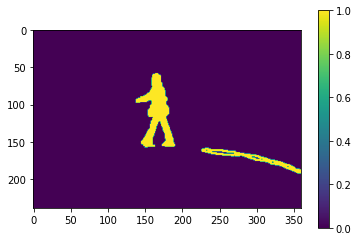

In [8]:
plt.imshow(gt_img)
plt.colorbar()

In [9]:
# Example Raw Image
raw_img = Image.open(raw_files[i])
raw_img = np.array(raw_img).astype(np.int32) / 255.0

In [16]:
p, q = raw_img.shape[0:2]

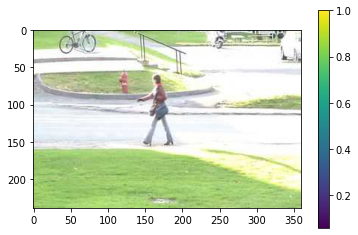

In [17]:
plt.imshow(raw_img)
plt.colorbar()

# R-PCA

In [106]:
# Part IV. Experimental Evaluation
# p, q = 240, 360  #
k = 100            # the number of frames
epsilon1 = 20      # the number of nearest neighbors

start_idx = 0

In [107]:
raw_batch = np.zeros((k, p * q))
gt_batch = np.zeros((k, p, q))
middle_name = raw_files[start_idx + k // 2]

for img_idx in range(k):
    # Example Raw Image
    raw_img = Image.open(raw_files[start_idx + img_idx])
    raw_img = np.array(raw_img) / 255.0  # with shape (p, q, 3)
    raw_img = raw_img.mean(axis=-1)
    raw_batch[img_idx] = raw_img.ravel()
    
    # Ground Truth Image
    gt_img = Image.open(gt_files[start_idx + img_idx])
    gt_img = np.array(gt_img)  # with shape (p, q)
    gt_img *= (gt_img == 255)  # reserve the Moving class with value 255
    gt_img = gt_img.astype(np.float64) / 255.0
    gt_batch[img_idx] = gt_img

In [108]:
# D = np.zeros((d, p * q))

# for k in range(d):
#     raw_img = data[:, :, k]
#     raw_vec = raw_img.ravel()
#     D[k] = raw_vec

In [109]:
t1 = time.time()
# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(raw_batch)
L, S = rpca.fit(max_iter=100, iter_print=1)
t2 = time.time()
print(t2 - t1)

iteration: 1, error: 16.320908213046007
iteration: 2, error: 7.34465539868624
iteration: 3, error: 4.485678942986565
iteration: 4, error: 2.9793070397594628
iteration: 5, error: 2.2528348579069952
iteration: 6, error: 1.7025888310159714
iteration: 7, error: 1.293094556967247
iteration: 8, error: 1.0354972425311202
iteration: 9, error: 0.8416237194625962
iteration: 10, error: 0.7036348017465519
iteration: 11, error: 0.6069763587327122
iteration: 12, error: 0.5316106520152405
iteration: 13, error: 0.4693515164089797
iteration: 14, error: 0.4167852580215523
iteration: 15, error: 0.3711894223881126
iteration: 16, error: 0.33057362312763006
iteration: 17, error: 0.2952373796441481
iteration: 18, error: 0.26587585059644714
iteration: 19, error: 0.24158035179223314
iteration: 20, error: 0.22136892121588367
iteration: 21, error: 0.2047793476561704
iteration: 22, error: 0.19082802245594227
iteration: 23, error: 0.17859210791655905
iteration: 24, error: 0.16788449622852994
iteration: 25, error: 

Text(0.5, 1.0, 'sparse foreground')

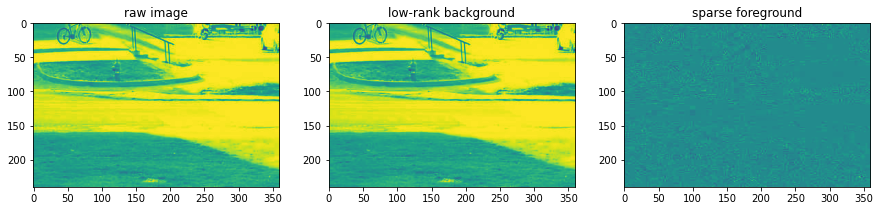

In [110]:
idx = 20

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

# raw image
a = raw_batch[idx]
a = a.reshape((p, q))
axs[0].imshow(a)
axs[0].set_title('raw image')

# low-rank background
b = L[idx]
b = b.reshape((p, q))
axs[1].imshow(b)
axs[1].set_title('low-rank background')

# sparse foreground
c = S[idx]
c = c.reshape((p, q))
axs[2].imshow(c)
axs[2].set_title('sparse foreground')

In [119]:
rpca_thres = -0.11
mask = (S < rpca_thres) * 1.0

In [120]:
mask = mask.reshape(-1, p, q)

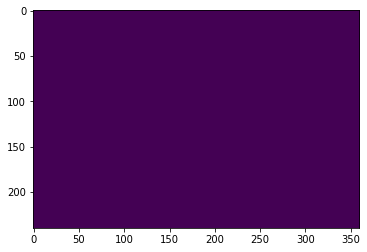

In [121]:
idx = 20
plt.imshow(mask[idx])

In [122]:
frame_mask = mask[idx]
frame_gt = gt_batch[idx]
y_predict = frame_mask.ravel()
y_true = frame_gt.ravel()
f1 = f1_score(y_true, y_predict)  # F1-score
f1

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.0

In [123]:
y_predict = mask.ravel()
y_true = gt_batch.ravel()

tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()  # confusion matrix
print(tn, fp, fn, tp)

8639912 88 0 0


In [124]:
P = tp / (tp + fp)
R = tp / (tp + fn)
P, R

/tmp/ipykernel_120/3990188850.py:2: RuntimeWarning: invalid value encountered in long_scalars
  R = tp / (tp + fn)


(0.0, nan)

In [125]:
f1 = 2 * P * R / (P + R)                              # F1-score

In [126]:
print(f1, R)

nan nan


## Evaluate the whole video

In [127]:
results_list = []

In [128]:
ww = 100
rpca_thres = -0.1

start_idx = 0
end_idx = start_idx + ww

In [129]:
while (start_idx < len(raw_files)):
    print(f"================================[Frame {start_idx}-{end_idx}]================================")
    # read window
    k = end_idx - start_idx  # this window's width, which may be smaller than ww in the last window
    raw_batch = np.zeros((k, p * q))
    gt_batch = np.zeros((k, p, q))
    for img_idx in range(k):
        # Raw Image Batch
        raw_img = Image.open(raw_files[start_idx + img_idx])
        raw_img = np.array(raw_img) / 255.0  # with shape (p, q, 3)
        raw_img = raw_img.mean(axis=-1)      # with shape (p, q)
        raw_batch[img_idx] = raw_img.ravel() # with shape (p * q)

        # Ground Truth Image Batch
        gt_img = Image.open(gt_files[start_idx + img_idx])
        gt_img = np.array(gt_img)  # with shape (p, q)
        gt_img *= (gt_img == 255)  # reserve the Moving class with value 255
        gt_img = gt_img.astype(np.float64) / 255.0
        gt_batch[img_idx] = gt_img
    
    ###################### RPCA ######################
    # 1. build the RPCA model
    t1 = time.time()
    rpca_model = R_pca(raw_batch)
    # 2. model fitting
    L, S = rpca_model.fit(max_iter=100, iter_print=1)
    # 3. thresholding
    mask = (S < rpca_thres) * 1.0
    mask = mask.reshape(-1, p, q)
    t2 = time.time()
    rpca_time = t2 - t1
    print(f"- fitting the RPCA model time cost: {rpca_time: .4f}")
    
    # evaluate the metrics
    # middle frame
    y_predict = frame_mask.ravel()
    y_true = frame_gt.ravel()
    # whole window
    y_predict = mask.ravel()
    y_true = gt_batch.ravel()
    conf_mat = confusion_matrix(y_true, y_predict).ravel()  # confusion matrix
    if len(conf_mat) == 1:
        tn, fp, fn, tp = conf_mat[0], 0, 0, 0
    else:
        tn, fp, fn, tp = conf_mat
    
    # record the results
    results_list.append([k, rpca_time, tn, fp, fn, tp])
    results_df = pd.DataFrame(results_list, columns=["k", "rpca_time", "tn", "fp", "fn", "tp"])
    results_df.to_csv(f"./results/rpca-{dataset_name}.csv")
    
    # update window index
    start_idx = end_idx
    end_idx = min(end_idx + ww, len(raw_files))

================================[Frame 0-100]================================
iteration: 1, error: 16.320908213046007
iteration: 2, error: 7.34465539868624
iteration: 3, error: 4.485678942986565
iteration: 4, error: 2.9793070397594628
iteration: 5, error: 2.2528348579069952
iteration: 6, error: 1.7025888310159714
iteration: 7, error: 1.293094556967247
iteration: 8, error: 1.0354972425311202
iteration: 9, error: 0.8416237194625962
iteration: 10, error: 0.7036348017465519
iteration: 11, error: 0.6069763587327122
iteration: 12, error: 0.5316106520152405
iteration: 13, error: 0.4693515164089797
iteration: 14, error: 0.4167852580215523
iteration: 15, error: 0.3711894223881126
iteration: 16, error: 0.33057362312763006
iteration: 17, error: 0.2952373796441481
iteration: 18, error: 0.26587585059644714
iteration: 19, error: 0.24158035179223314
iteration: 20, error: 0.22136892121588367
iteration: 21, error: 0.2047793476561704
iteration: 22, error: 0.19082802245594227
iteration: 23, error: 0.1785

- F1 score

In [135]:
total_fp = results_df.fp.sum()
total_fn = results_df.fn.sum()
total_tp = results_df.tp.sum()

In [136]:
f1, Recall, Precision = compute_metrics(total_fp, total_fn, total_tp)
f1, Recall, Precision

(0.6818333075727131, 0.8383929928957073, 0.5745441767293907)

- Average time:

In [137]:
total_time = results_df.rpca_time.sum()
n = results_df.k.sum()

In [138]:
avg_time = total_time / n
avg_time

1.0263834422669484